In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!head "/content/drive/My Drive/ML101/CADJPY.csv"
train_file_path = "/content/drive/My Drive/ML101/CADJPY.csv"

Mounted at /content/drive
Date,Open,High,Low,Close,Adj Close,Volume
2005-01-03,85.387001,85.549004,84.778999,85.038002,85.038002,0
2005-01-04,85.044998,85.599998,84.814003,85.389999,85.389999,0
2005-01-05,85.425003,85.531998,84.730003,84.844002,84.844002,0
2005-01-06,84.883003,85.358002,84.720001,84.880997,84.880997,0
2005-01-07,84.875000,85.221001,84.580002,85.151001,85.151001,0
2005-01-10,84.954002,85.570000,84.934998,85.303001,85.303001,0
2005-01-11,85.301003,85.480003,84.670998,84.821999,84.821999,0
2005-01-12,84.822998,85.662003,84.580002,85.237000,85.237000,0
2005-01-13,85.244003,85.468002,84.987999,85.199997,85.199997,0


# Build a SKLearn linear regression model to predict CAD/JPY exchange rate returns with lagged CAD/JPY exchange rate returns.

# **Regression Analysis: Seasonal Effects with Sklearn Linear Regression**

In [ ]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(train_file_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
cad_jpy_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,85.387001,85.549004,84.778999,85.038002,85.038002,0.0
2005-01-04,85.044998,85.599998,84.814003,85.389999,85.389999,0.0
2005-01-05,85.425003,85.531998,84.730003,84.844002,84.844002,0.0
2005-01-06,84.883003,85.358002,84.720001,84.880997,84.880997,0.0
2005-01-07,84.875000,85.221001,84.580002,85.151001,85.151001,0.0


**Data Preparation**

**Lagged Returns**

In [ ]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results
cad_jpy_df['Return'] = (cad_jpy_df[['Close']].pct_change() * 100)
cad_jpy_df = cad_jpy_df.replace(-np.inf, np.nan).dropna()

# Create a lagged return
cad_jpy_df['Lagged_Return'] = cad_jpy_df["Return"].shift()
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Return,Lagged_Return
Date,,,,,,,,
2022-12-26,97.373001,98.007942,97.155998,97.373001,97.373001,0.0,0.355568,-0.176952
2022-12-27,97.913002,98.849998,97.829002,97.913002,97.913002,0.0,0.554570,0.355568
2022-12-28,98.680000,99.292000,98.683998,98.680000,98.680000,0.0,0.783346,0.554570
2022-12-29,98.539001,98.681000,97.999001,98.539001,98.539001,0.0,-0.142885,0.783346
2022-12-30,98.053001,98.058998,97.197998,98.053001,98.053001,0.0,-0.493206,-0.142885


**Train Test Split**

In [ ]:
# Define window length for rolling window
window_length = 750  # roughly three years of trading days

# Create empty lists to store the training sets, test sets, and predictions
train_sets = []
test_sets = []
predictions = []

# Iterate over each window in the dataset
for i in range(window_length, len(cad_jpy_df), window_length):
    # Extract the window of data ending at day i
    train = cad_jpy_df.iloc[i-window_length:i]

    # Add the window to the list of training sets
    train_sets.append(train)

    # If there's enough data left for a test set, extract it and add it to the list of test sets
    if i + 1 < len(cad_jpy_df):
        test = cad_jpy_df.iloc[i:i+1]
        test_sets.append(test)

# Iterate over each training and test set, fit the model, and make a prediction
for i in range(len(train_sets)):
    # Get the training data
    x_train = train_sets[i]["Lagged_Return"].values.reshape(-1, 1)
    y_train = train_sets[i]["Return"].values

    # Fit the model to the training data
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Get the test data
    x_test = test_sets[i]["Lagged_Return"].values.reshape(-1, 1)
    y_test = test_sets[i]["Return"].values

    # Make a prediction on the test data and add it to the list of predictions
    prediction = model.predict(x_test)
    predictions.append(prediction[0])

# Convert the list of predictions to a numpy array
predictions = np.array(predictions)

# Print the shape and size of the predictions
print(f'predictions shape: {predictions.shape}')
print(f'predictions size: {predictions.size}')

# Print the predictions
print(f'predictions: {predictions}')


predictions shape: (6,)
predictions size: 6
predictions: [ 0.01286606 -0.04948551  0.01030542 -0.06346583 -0.0113036   0.02495872]


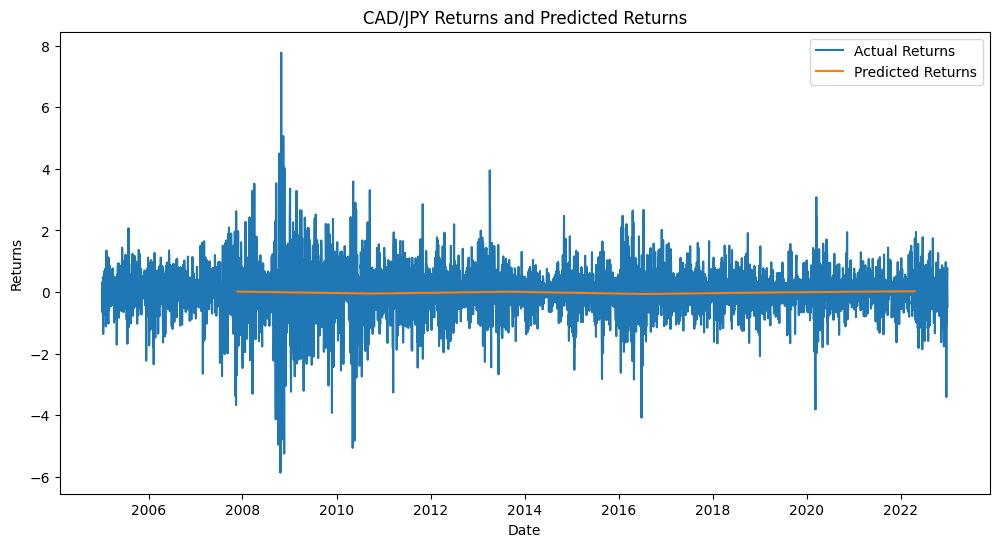

In [ ]:
# First, we create an index for predictions. It should match with the days following each window.
pred_index = cad_jpy_df.index[window_length::window_length][:len(predictions)]

# Convert predictions into a pandas Series for easier plotting
predictions_series = pd.Series(predictions, index=pred_index)

# Plotting the actual returns and the predicted returns
plt.figure(figsize=(12,6))
plt.plot(cad_jpy_df['Return'], label='Actual Returns')
plt.plot(predictions_series, label='Predicted Returns')
plt.title('CAD/JPY Returns and Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()



# **Random Forest & KNN Models**

In [ ]:
# Prepare different models
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=3),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5)
}

# Iterate over each training and test set, fit the model, and make a prediction
for model_name, model in models.items():
    model_predictions = []

    for i in range(len(train_sets)):
        # Get the training data
        x_train = train_sets[i]["Lagged_Return"].values.reshape(-1, 1)
        y_train = train_sets[i]["Return"].values

        # Fit the model to the training data
        model.fit(x_train, y_train)

        # Get the test data
        x_test = test_sets[i]["Lagged_Return"].values.reshape(-1, 1)
        y_test = test_sets[i]["Return"].values

        # Make a prediction on the test data and add it to the list of predictions
        prediction = model.predict(x_test)
        model_predictions.append(prediction[0])

    # Convert the list of predictions to a numpy array
    model_predictions = np.array(model_predictions)

    # Print the shape, size, and predictions of the model
    print(f'{model_name} predictions shape: {model_predictions.shape}')
    print(f'{model_name} predictions size: {model_predictions.size}')
    print(f'{model_name} predictions: {model_predictions}\n')

# **Linear Regression Model**

In [ ]:
# Fit the model to the training data and make predictions on the test data
model = LinearRegression()
model.fit(x_train_rolling, y_train_rolling)
predictions = model.predict(x_test_rolling.reshape(-1, 1))

ValueError: ignored

# **Make predictions using the Testing Data**

In [ ]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(x_test)
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results["Predicted Return"] = predictions
results.head(2)

#-0.305060是2018年1月1日的實際回報率，-0.010324是模型預測的回報率
#最後，可以將這些值用於評估模型的性能，例如計算R-squared,（MSE）和（MAE）等指標。

,Return,Predicted Return
Date,,
2007-01-01,-0.166306,0.007767
2007-01-02,-0.058800,0.004898


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

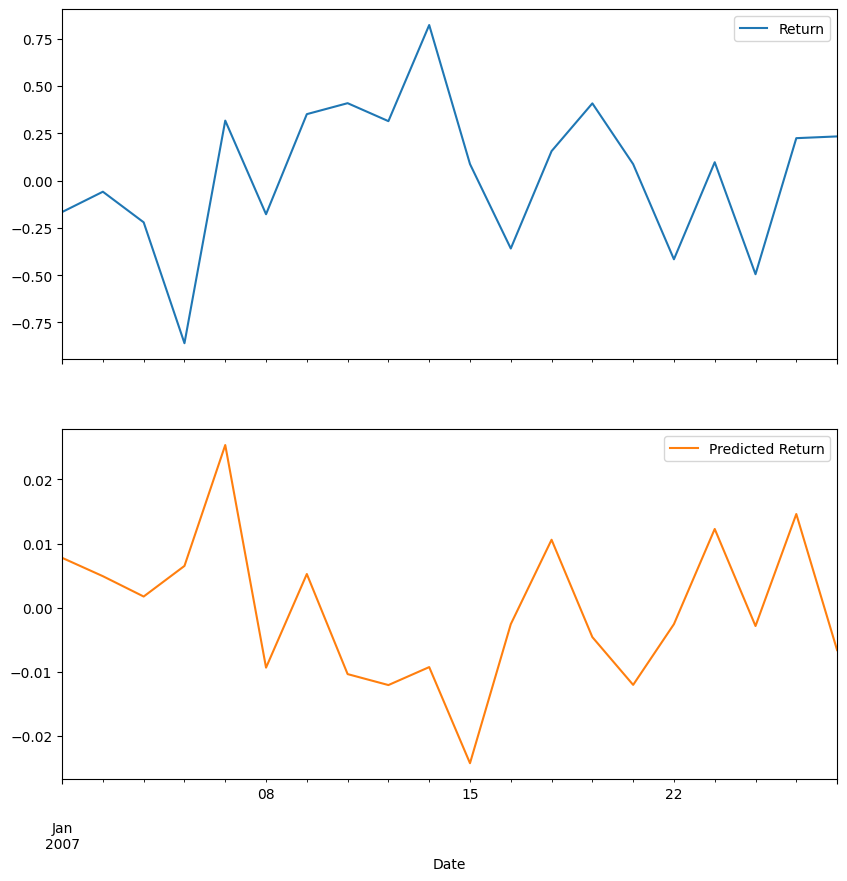

In [ ]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True, figsize = (10, 10))

# **Random Forest**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max depth =10) #hyperparameter
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)

**evaluate**

In [ ]:
print(f"Random Forest Regression R-squared: {r2_score(y_test, rf_predictions):.4f}")
print(f"Random Forest Regression MSE: {mean_squared_error(y_test, rf_predictions):.4f}")

Random Forest Regression R-squared: -0.5726
Random Forest Regression MSE: 1.1554


# **KNN**

In [ ]:
# Create a KNN regression model and fit it to the training data
model = KNeighborsRegressor(n_neighbors=5)
model.fit(x_train, y_train)

KNeighborsRegressor()

In [ ]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(x_test)
# Evaluate the performance of the model using mean squared error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

MSE: 0.8828349130109989


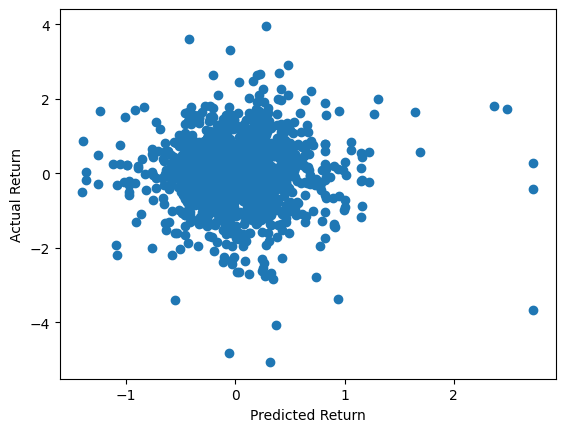

In [ ]:
# Create a scatter plot of the predicted returns vs the actual returns
plt.scatter(predictions, y_test)
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive')
!head "/content/drive/My Drive/ML101/CADJPY.csv"
train_file_path = "/content/drive/My Drive/ML101/CADJPY.csv"
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(train_file_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
cad_jpy_df.head()
# Create a series using "Price" percentage returns, drop any nan"s, and check the results
cad_jpy_df['Return'] = (cad_jpy_df[['Close']].pct_change() * 100)
cad_jpy_df = cad_jpy_df.replace(-np.inf, np.nan).dropna()

# Create a lagged return
cad_jpy_df['Lagged_Return'] = cad_jpy_df["Return"].shift()
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.tail()
# Define window length for rolling window
window_length = 750  # roughly three years of trading days

# Create empty lists to store the training sets, test sets, and predictions
train_sets = []
test_sets = []
predictions = []

# Iterate over each window in the dataset
for i in range(window_length, len(cad_jpy_df), window_length):
    # Extract the window of data ending at day i
    train = cad_jpy_df.iloc[i-window_length:i]

    # Add the window to the list of training sets
    train_sets.append(train)

    # If there's enough data left for a test set, extract it and add it to the list of test sets
    if i + 1 < len(cad_jpy_df):
        test = cad_jpy_df.iloc[i:i+1]
        test_sets.append(test)

# Iterate over each training and test set, fit the model, and make a prediction
for i in range(len(train_sets)):
    # Get the training data
    x_train = train_sets[i]["Lagged_Return"].values.reshape(-1, 1)
    y_train = train_sets[i]["Return"].values

    # Fit the model to the training data
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Get the test data
    x_test = test_sets[i]["Lagged_Return"].values.reshape(-1, 1)
    y_test = test_sets[i]["Return"].values

    # Make a prediction on the test data and add it to the list of predictions
    prediction = model.predict(x_test)
    predictions.append(prediction[0])

# Convert the list of predictions to a numpy array
predictions = np.array(predictions)

# Print the shape and size of the predictions
print(f'predictions shape: {predictions.shape}')
print(f'predictions size: {predictions.size}')

# Print the predictions
print(f'predictions: {predictions}')


predictions shape: (6,)
predictions size: 6
predictions: [ 0.01286606 -0.04948551  0.01030542 -0.06346583 -0.0113036   0.02495872]
